# Comparison of large scale horizontal surface gradients of temperature, salinity and buoyancy with hydrographic data

__author__ : Aurélie Albert, Julien Le Sommer (MEOM, IGE)

__contributing author__ : Guillaume Sérazin (UNSW)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : 14 December 2018

__purpose__ : Comparison of large scale horizontal surface gradients of temperature, salinity and buoyancy with hydrographic data

__detailed description__ : 

In the following maps, the median within 1°x1° bins of the surface horizontal gradients of large scale quantitities are shown :

$$\overline{grad_h(X^{'})}^{t,x,y}$$

with X are surface temperature, salinity and buoyancy, prime respresents the large scale component and $\overline{X}^{t,x,y}$ stands for a boxcar median.


__practical steps__ :

Preliminary steps :
1. spatial filtering with cut-off frequency of 10 grid points (~10km) of daily surface outputs of temperature, salinity and buoyancy  : script `/home/albert7a/python/filtering/make_filt_sst_sss_fc10.ksh`, results in `/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/filt/`, files `NATL60-CJM165_y*.1d_hgradT/S/buoy_filt-n80-f0.1.nc`, we keep the large scale part of the filtering process … (on occigen)
1. computation of horizontal gradient with cdftool cdfhgrad, script : `/home/albert7a/EXTRACT/compute_hgrad_surf_TS_filt.ksh` (on occigen)
1. binning 1°x1° and median over the year : https://github.com/auraoupa/CMEMS-diags/blob/master/TSG_Guillaume/binning_1file_3month.py, results `/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_JFM/JAS_hgradT/S_filt10km_bin1x1.nc`
1. filtered horizontal gradients of thermosalinograph data provided by Guillaume Sérazin


Operations described in the following notebook :
1. Maps of binned gradients
2. Map of data distribution
3. Histograms of gradients in 3 boxes

  
__external libraries needed to run this script__ : 

 * Definition of the 3 5°x5° for NATL60 grid : natl60_3_5_by_5_boxes
 * seaborn : only for histogram colors
 * cmclimate : https://github.com/serazing/cmclimate.git
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In [26]:
# Import modules

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy.ma as ma
import sys
sys.path.insert(0,"/home/albert/Work/git/cmclimate")
import cmclimate
import os
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns
sns.set(color_codes=True)

sys.path.insert(0,'/home/albert//Work/git/CMEMS-diags/')
from natl60_3_5_by_5_boxes import boxes
sys.path.insert(0,'/home/albert/lib/python/AJ-spectre/')
import plot_box as pb


In [27]:
# Load TSG data

## all the data
ds_TSG = xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/TSG/ALL_horizontal_gradients.nc', chunks={'time': 1e7})

## median of binned data
ds_hgradT_TSG=xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/TSG/ALL_temperature_gradients_1x1.nc')
ds_hgradS_TSG=xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/TSG/ALL_salinity_gradients_1x1.nc')
ds_hgradb_TSG=xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/TSG/ALL_buoyancy_gradients_1x1.nc')

hgradT_TSG=ds_hgradT_TSG['SST_LS']
hgradS_TSG=ds_hgradS_TSG['SSS_LS']
hgradb_TSG=ds_hgradb_TSG['SSb_LS']


In [28]:
# Load NATL60 outputs

## all the data
ds_natl_T = xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2012m10d01-y2013m09d30.1d_hgradT_large-n80-f0.1.nc',chunks={'time_counter':1})
ds_natl_S = xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2012m10d01-y2013m09d30.1d_hgradS_large-n80-f0.1.nc',chunks={'time_counter':1})
ds_natl_b = xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2012m10d01-y2013m09d30.1d_hgradb_large-n80-f0.1.nc',chunks={'time_counter':1})

## median of binned data
ds_hgradT_natl=xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_year_hgradT_filt10km_bin1x1.nc')
ds_hgradS_natl=xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_year_hgradS_filt10km_bin1x1.nc')
ds_hgradb_natl=xr.open_dataset('/mnt/albert/equipes/meom/workdir/albert/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_year_hgradb_filt10km_bin1x1.nc')

hgradT_natl=ds_hgradT_natl['vohgradb']
hgradS_natl=ds_hgradS_natl['vohgradb']
hgradb_natl=ds_hgradb_natl['vohgradb']


In [29]:
# plot layout for maps of binned data

def map_bin(sub,data,lon,lat,vmin,vmax,title):

    norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)

    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((-85, 20, 25, 70))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)
    plt.pcolormesh(lon,lat,data,cmap=cmclimate.cm.BlGrYeOrReVi200, norm=norm)
    plt.colorbar()
    plt.title(title)
    for box in boxes:
        x1 = box.lonmin
        x2 = box.lonmax
        y1 = box.latmin
        y2 = box.latmax
        ax.plot([x1, x2], [y1, y1],color='black',linewidth=4)
        ax.plot([x1, x2], [y2, y2],color='black',linewidth=4)
        ax.plot([x1, x1], [y1, y2],color='black',linewidth=4)
        ax.plot([x2, x2], [y1, y2],color='black',linewidth=4)
        ax.text((x1+x2)/2,y1-2.5,box.name, fontsize=22)
    

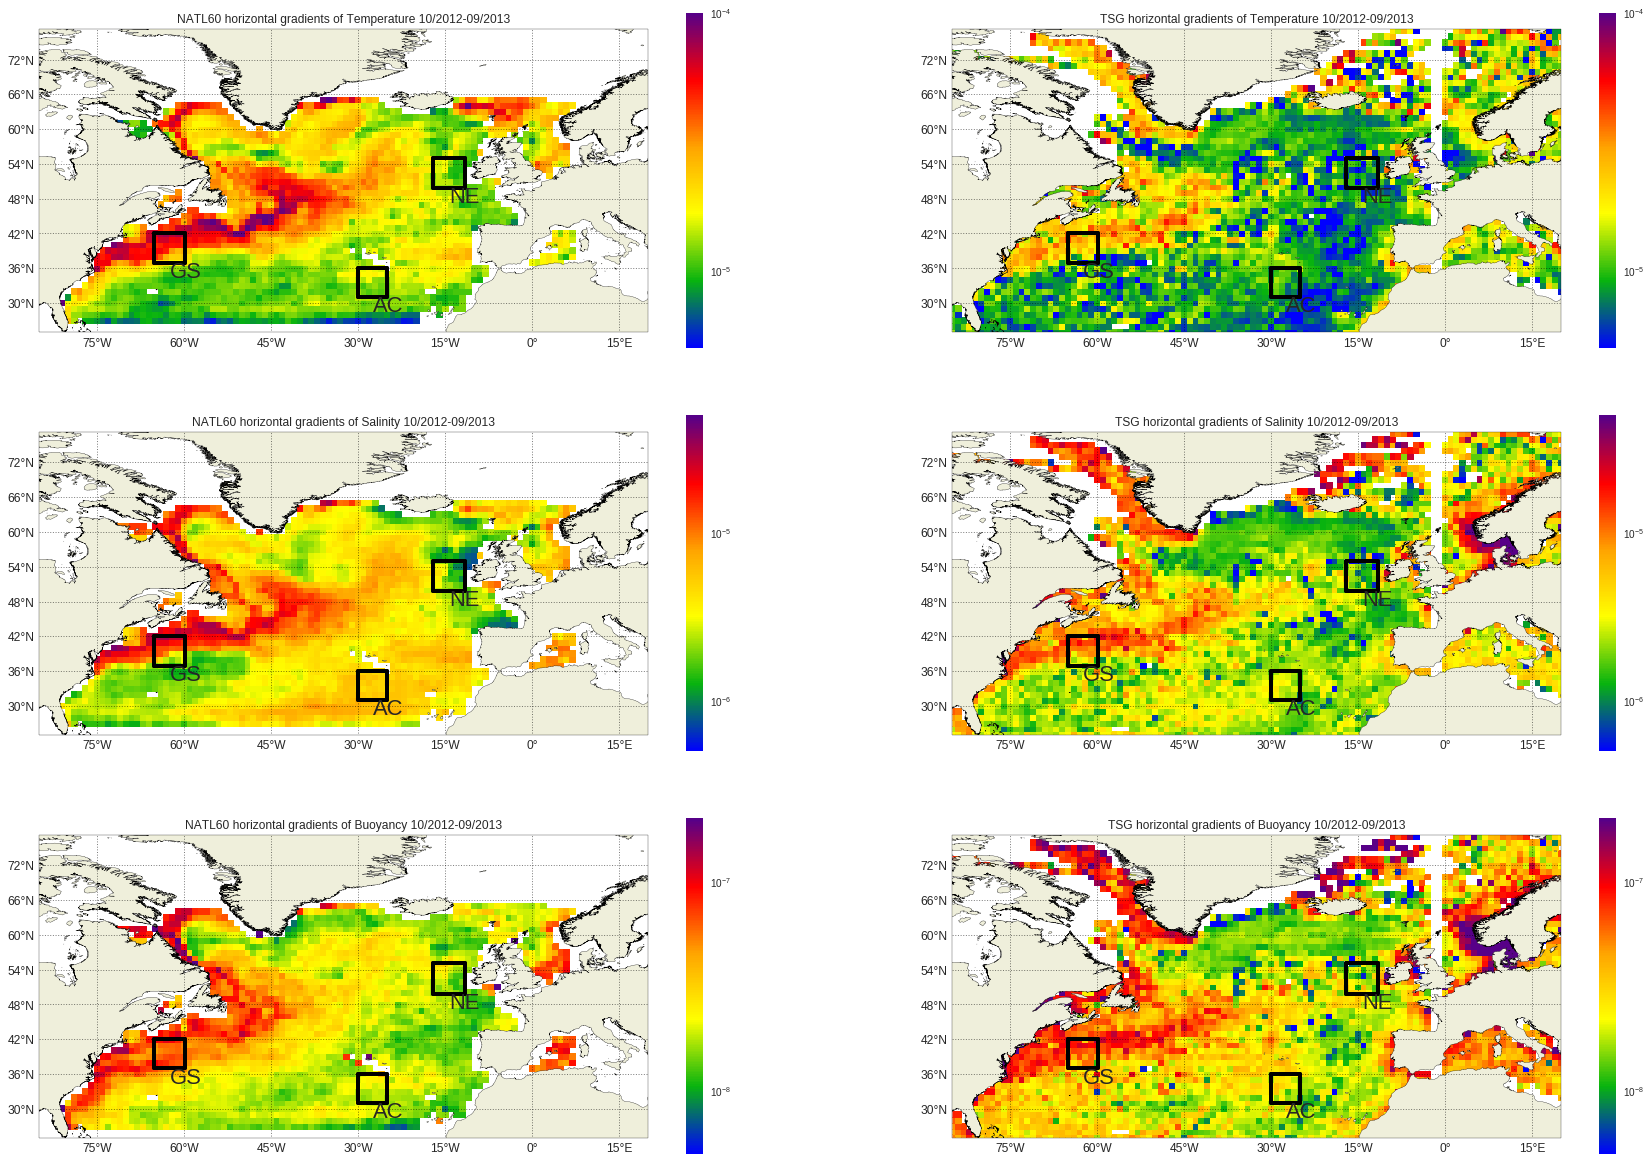

In [30]:
# apply it to NATL60 and TSG data for temperature, salinity and buoyancy

fig=plt.figure(figsize=(30,21))
map_bin(321,ma.masked_invalid(ds_hgradT_natl['vohgradb']),ds_hgradT_natl['nav_lon'],ds_hgradT_natl['nav_lat'],5e-6,1e-4,'NATL60 horizontal gradients of Temperature 10/2012-09/2013')
map_bin(323,ma.masked_invalid(ds_hgradS_natl['vohgradb']),ds_hgradT_natl['nav_lon'],ds_hgradT_natl['nav_lat'],5e-7,5e-5,'NATL60 horizontal gradients of Salinity 10/2012-09/2013')
map_bin(325,ma.masked_invalid(ds_hgradb_natl['vohgradb']),ds_hgradT_natl['nav_lon'],ds_hgradT_natl['nav_lat'],5e-9,2e-7,'NATL60 horizontal gradients of Buoyancy 10/2012-09/2013')
map_bin(322,ma.masked_invalid(ds_hgradT_TSG['SST_LS']),ds_hgradT_TSG['lon'],ds_hgradT_TSG['lat'],5e-6,1e-4,'TSG horizontal gradients of Temperature 10/2012-09/2013')
map_bin(324,ma.masked_invalid(ds_hgradS_TSG['SSS_LS']),ds_hgradT_TSG['lon'],ds_hgradT_TSG['lat'],5e-7,5e-5,'TSG horizontal gradients of Salinity 10/2012-09/2013')
map_bin(326,ma.masked_invalid(ds_hgradb_TSG['SSb_LS']),ds_hgradT_TSG['lon'],ds_hgradT_TSG['lat'],5e-9,2e-7,'TSG horizontal gradients of Buoyancy 10/2012-09/2013')

In [33]:
# aggregate data in 3 boxes GS, NE and AC

GSbox=(-65+360,-60+360,37,42)
NEbox=(-17+360,-12+360,50,55)
ACbox=(-30+360,-25+360,31,36)
_lon=ds_TSG['lon'][:]
_lat=ds_TSG['lat'][:]

domainGS=(GSbox[0]<_lon)*(_lon<GSbox[1])*(GSbox[2]<_lat)*(_lat<GSbox[3])

whereGS=np.where(domainGS)

latsGS=_lat[whereGS[0][:]]
lonsGS=_lon[whereGS[0][:]]

gradTGS=ds_TSG['SST_LS'][whereGS[0][:]]
gradSGS=ds_TSG['SSS_LS'][whereGS[0][:]]
gradbGS=ds_TSG['SSb_LS'][whereGS[0][:]]

domainNE=(NEbox[0]<_lon)*(_lon<NEbox[1])*(NEbox[2]<_lat)*(_lat<NEbox[3])

whereNE=np.where(domainNE)

latsNE=_lat[whereNE[0][:]]
lonsNE=_lon[whereNE[0][:]]

gradTNE=ds_TSG['SST_LS'][whereNE[0][:]]
gradSNE=ds_TSG['SSS_LS'][whereNE[0][:]]
gradbNE=ds_TSG['SSb_LS'][whereNE[0][:]]

domainAC=(ACbox[0]<_lon)*(_lon<ACbox[1])*(ACbox[2]<_lat)*(_lat<ACbox[3])

whereAC=np.where(domainAC)

latsAC=_lat[whereAC[0][:]]
lonsAC=_lon[whereAC[0][:]]

gradTAC=ds_TSG['SST_LS'][whereAC[0][:]]
gradSAC=ds_TSG['SSS_LS'][whereAC[0][:]]
gradbAC=ds_TSG['SSb_LS'][whereAC[0][:]]

gradTGS_nonan=gradTGS[~np.isnan(gradTGS)]
gradSGS_nonan=gradSGS[~np.isnan(gradSGS)]
gradbGS_nonan=gradbGS[~np.isnan(gradbGS)]
gradTNE_nonan=gradTNE[~np.isnan(gradTNE)]
gradSNE_nonan=gradSNE[~np.isnan(gradSNE)]
gradbNE_nonan=gradbNE[~np.isnan(gradbNE)]
gradTAC_nonan=gradTAC[~np.isnan(gradTAC)]
gradSAC_nonan=gradSAC[~np.isnan(gradSAC)]
gradbAC_nonan=gradbAC[~np.isnan(gradbAC)]

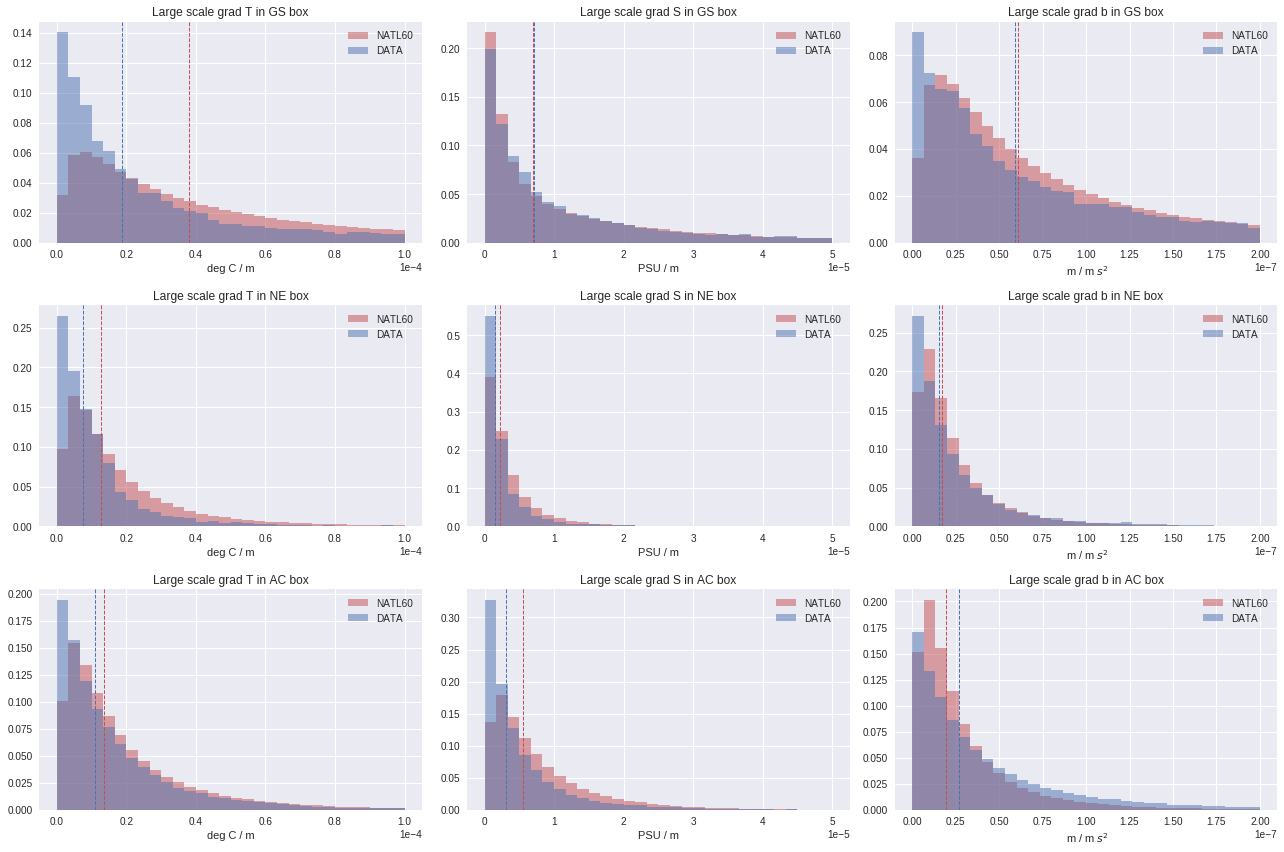

In [34]:
# histograms in these 3 boxes, comparison between natl60 and data

fig = plt.figure(figsize=(18.0, 12.0))

for box in boxes:
    
    gradT=ds_natl_T['vohgradb'][:,box.jmin:box.jmax,box.imin:box.imax].stack(z=('x', 'y','time_counter'))
    gradS=ds_natl_S['vohgradb'][:,box.jmin:box.jmax,box.imin:box.imax].stack(z=('x', 'y','time_counter'))
    gradb=ds_natl_b['vohgradb'][:,box.jmin:box.jmax,box.imin:box.imax].stack(z=('x', 'y','time_counter'))
    
    gradT_nonan=gradT[~np.isnan(gradT)]
    gradS_nonan=gradS[~np.isnan(gradS)]
    gradb_nonan=gradb[~np.isnan(gradb)]
    
    
    axes1 = fig.add_subplot(3, 3, (box.nb-1)*3+1)
    weights = np.ones_like(gradT_nonan)/float(len(gradT_nonan))
    med=np.median(np.abs(gradT_nonan))
    axes1.hist(gradT_nonan,30, alpha = 0.5,range=(0,1e-4),color='r', weights=weights, label='NATL60')
    axes1.axvline(med, color='r', linestyle='dashed', linewidth=1)
    if box.name == 'GS':
        weights = np.ones_like(gradTGS_nonan)/float(len(gradTGS_nonan))
        med=np.median(np.abs(gradTGS_nonan))
        axes1.hist(np.abs(gradTGS_nonan),30, alpha = 0.5,range=(0,1e-4),color='b', weights=weights, label='DATA')
        axes1.axvline(med, color='b', linestyle='dashed', linewidth=1)
    if box.name == 'NE':
        weights = np.ones_like(gradTNE_nonan)/float(len(gradTNE_nonan))
        med=np.median(np.abs(gradTNE_nonan))
        axes1.hist(np.abs(gradTNE_nonan),30, alpha = 0.5,range=(0,1e-4),color='b', weights=weights, label='DATA')
        axes1.axvline(med, color='b', linestyle='dashed', linewidth=1)
    if box.name == 'AC':
        weights = np.ones_like(gradTAC_nonan)/float(len(gradTAC_nonan))
        med=np.median(np.abs(gradTAC_nonan))
        axes1.hist(np.abs(gradTAC_nonan),30, alpha = 0.5,range=(0,1e-4),color='b', weights=weights, label='DATA')
        axes1.axvline(med, color='b', linestyle='dashed', linewidth=1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('deg C / m')
    plt.legend()
    plt.title('Large scale grad T in '+box.name+' box')

    axes2 = fig.add_subplot(3, 3, (box.nb-1)*3+2)
    weights = np.ones_like(gradS_nonan)/float(len(gradS_nonan))
    med=np.median(np.abs(gradS_nonan))
    axes2.hist(gradS_nonan,30, alpha = 0.5,range=(0,5e-5),color='r', weights=weights, label='NATL60')
    axes2.axvline(med, color='r', linestyle='dashed', linewidth=1)
    if box.name == 'GS':
        weights = np.ones_like(gradSGS_nonan)/float(len(gradSGS_nonan))
        med=np.median(np.abs(gradSGS_nonan))
        axes2.hist(np.abs(gradSGS_nonan),30, alpha = 0.5,range=(0,5e-5),color='b', weights=weights, label='DATA')
        axes2.axvline(med, color='b', linestyle='dashed', linewidth=1)
    if box.name == 'NE':
        weights = np.ones_like(gradSNE_nonan)/float(len(gradSNE_nonan))
        med=np.median(np.abs(gradSNE_nonan))
        axes2.hist(np.abs(gradSNE_nonan),30, alpha = 0.5,range=(0,5e-5),color='b', weights=weights, label='DATA')
        axes2.axvline(med, color='b', linestyle='dashed', linewidth=1)
    if box.name == 'AC':
        weights = np.ones_like(gradSAC_nonan)/float(len(gradSAC_nonan))
        med=np.median(np.abs(gradSAC_nonan))
        axes2.hist(np.abs(gradSAC_nonan),30, alpha = 0.5,range=(0,5e-5),color='b', weights=weights, label='DATA')
        axes2.axvline(med, color='b', linestyle='dashed', linewidth=1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('PSU / m')
    plt.legend()
    plt.title('Large scale grad S in '+box.name+' box')

    axes3 = fig.add_subplot(3, 3, (box.nb-1)*3+3)
    weights = np.ones_like(gradb_nonan)/float(len(gradb_nonan))
    med=np.median(np.abs(gradb_nonan))
    axes3.hist(gradb_nonan,30, alpha = 0.5,range=(0,2e-7),color='r', weights=weights, label='NATL60')
    axes3.axvline(med, color='r', linestyle='dashed', linewidth=1)
    if box.name == 'GS':
        weights = np.ones_like(gradbGS_nonan)/float(len(gradbGS_nonan))
        med=np.median(np.abs(gradbGS_nonan))
        axes3.hist(np.abs(gradbGS_nonan),30, alpha = 0.5,range=(0,2e-7),color='b', weights=weights, label='DATA')
        axes3.axvline(med, color='b', linestyle='dashed', linewidth=1)
    if box.name == 'NE':
        weights = np.ones_like(gradbNE_nonan)/float(len(gradbNE_nonan))
        med=np.median(np.abs(gradbNE_nonan))
        axes3.hist(np.abs(gradbNE_nonan),30, alpha = 0.5,range=(0,2e-7),color='b', weights=weights, label='DATA')
        axes3.axvline(med, color='b', linestyle='dashed', linewidth=1)
    if box.name == 'AC':
        weights = np.ones_like(gradbAC_nonan)/float(len(gradbAC_nonan))
        med=np.median(np.abs(gradbAC_nonan))
        axes3.hist(np.abs(gradbAC_nonan),30, alpha = 0.5,range=(0,2e-7),color='b', weights=weights, label='DATA')
        axes3.axvline(med, color='b', linestyle='dashed', linewidth=1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel(' m / m $s^2$')
    plt.legend()
    plt.title('Large scale grad b in '+box.name+' box')
fig.tight_layout()
